In [ ]:
# INTEL CORPORATION CONFIDENTIAL AND PROPRIETARY
# 
# Copyright © 2018-2021 Intel Corporation.
# 
# This software and the related documents are Intel copyrighted
# materials, and your use of them is governed by the express 
# license under which they were provided to you (License). Unless
# the License provides otherwise, you may not use, modify, copy, 
# publish, distribute, disclose or transmit  this software or the
# related documents without Intel's prior written permission.
# 
# This software and the related documents are provided as is, with
# no express or implied warranties, other than those that are 
# expressly stated in the License.

In [1]:
%config IPCompleter.greedy=True
import matplotlib.pyplot as plt
import numpy as np
import nxsdk.api.n2a as nx

# Connecting compartments
Compartments can be connected to other compartments via a connections. Just like compartment groups, connection groups use connection prototypes to configure the individual connections contained in the group. See the documentation for a list of all configurable connection parameters.
Here we connect different source and destination compartments to focus on different features of connections:
1. First, we'll create a connection with mostly default parameters between two single compartments.
2. Next we illustrate how to connect compartment groups and assign discrete weight and delay matrices.
3. Then we show how to create excitatory, inhibitory as well as mixed sign weights.
4. Finally we demonstrate how to use the two different post synaptic response modes.

![Connecting Compartments](figures/jupyter_connecting_compartments.png)

## 1. Connecting single compartments
For the first example, we connect two individual compartments with mostly default paramters with a weight 10 and a weight scaling exponent of 1. Thus the accumulated weights in the post synaptic compartment from each input will be 10 * 2 ** (6+1)=1280. The exponent of 6 is an implicit global scaling of all weights. 

SLURM is being run in background
Connecting to 134.134.68.80:18861
N2Driver: Running...
    Compiling synapses... Done (0.00s)
    Processing probes... Done (0.00s)
    Writing modified registers... Done (0.05s)
    Initializing... Done (0.01s)
    Preparing input... Done (0.00s)
    Executing... Done (0.01s)
    Processing timeSeries... Done (0.01s)
N2Driver: Finished (0.08s)


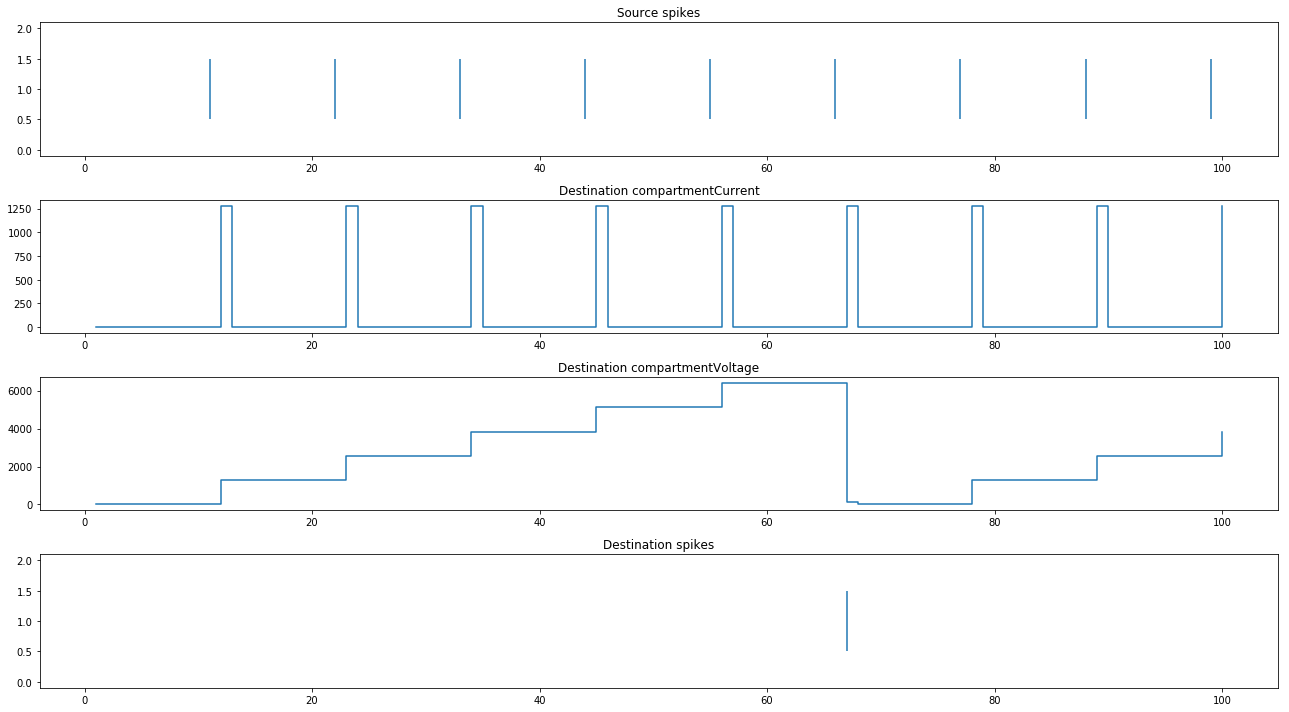

In [2]:
# Create an empty network.
net = nx.NxNet()

# Create source compartment
cxProtoSrc = nx.CompartmentPrototype(biasMant=1000,
                                     biasExp=6,
                                     vThMant=10000,                              
                                     functionalState=nx.COMPARTMENT_FUNCTIONAL_STATE.IDLE)
cxSrc = net.createCompartment(prototype=cxProtoSrc)

# Create destination compartment
cxProtoDst = nx.CompartmentPrototype(vThMant=100,
                                     compartmentCurrentDecay=4095)
cxDst = net.createCompartment(prototype=cxProtoDst)

# Connect compartments
connProto = nx.ConnectionPrototype(weight=10, weightExponent=1)
conn = cxSrc.connect(cxDst, prototype=connProto)

# Define probes
cxSrcSProbe = cxSrc.probe(nx.ProbeParameter.SPIKE)[0]
cxDstUProbe = cxDst.probe(nx.ProbeParameter.COMPARTMENT_CURRENT)[0]
cxDstVProbe = cxDst.probe(nx.ProbeParameter.COMPARTMENT_VOLTAGE)[0]
cxDstSProbe = cxDst.probe(nx.ProbeParameter.SPIKE)[0]

# Run network
net.run(100)
net.disconnect()

# Plot results
plt.figure(1, figsize=(18,10))

ax1 = plt.subplot(4,1,2)
uh = cxDstUProbe.plot()
plt.title('Destination compartmentCurrent')

ax2 = plt.subplot(4,1,3)
vh = cxDstVProbe.plot()
plt.title('Destination compartmentVoltage')

ax3 = plt.subplot(4,1,4)
sh = cxDstSProbe.plot()
ax3.set_xlim(ax1.get_xlim())
plt.title('Destination spikes')

ax0 = plt.subplot(4,1,1)
srch = cxSrcSProbe.plot()
ax0.set_xlim(ax1.get_xlim())
plt.title('Source spikes')
    
plt.tight_layout()
plt.show()

# Since the compartmentCurrentDecay is set to its maximum value, the compartmentCurrent decays instantly. The 
# membrane threshold is set to 100*2**6=6400, so it takes six spikes to drive the membrane above the threshold and cause
# a destination output spike.

## 2. Connecting compartment groups with discrete weight and delay matrices
Often, we'd like to assign discrete weights and delays to a connection group. This can be done by passing a weight and delay matrix to the connect(..) method. Passing in such a weight and delay matrix will overwrite the corresponding default paramter set in the connection prototype. 
By default, this will connect all source comaprtments to all destination compartments. If the connectivity is sparse, we can pass an additional binary connection mask to the connect(..) method where each non-zero element specifies for which connections to allocate memory.

SLURM is being run in background
Connecting to 134.134.68.80:18861
N2Driver: Running...
    Compiling synapses... Done (0.00s)
    Processing probes... Done (0.00s)
    Writing modified registers... Done (0.05s)
    Initializing... Done (0.01s)
    Preparing input... Done (0.00s)
    Executing... Done (0.01s)
    Processing timeSeries... Done (0.01s)
N2Driver: Finished (0.08s)


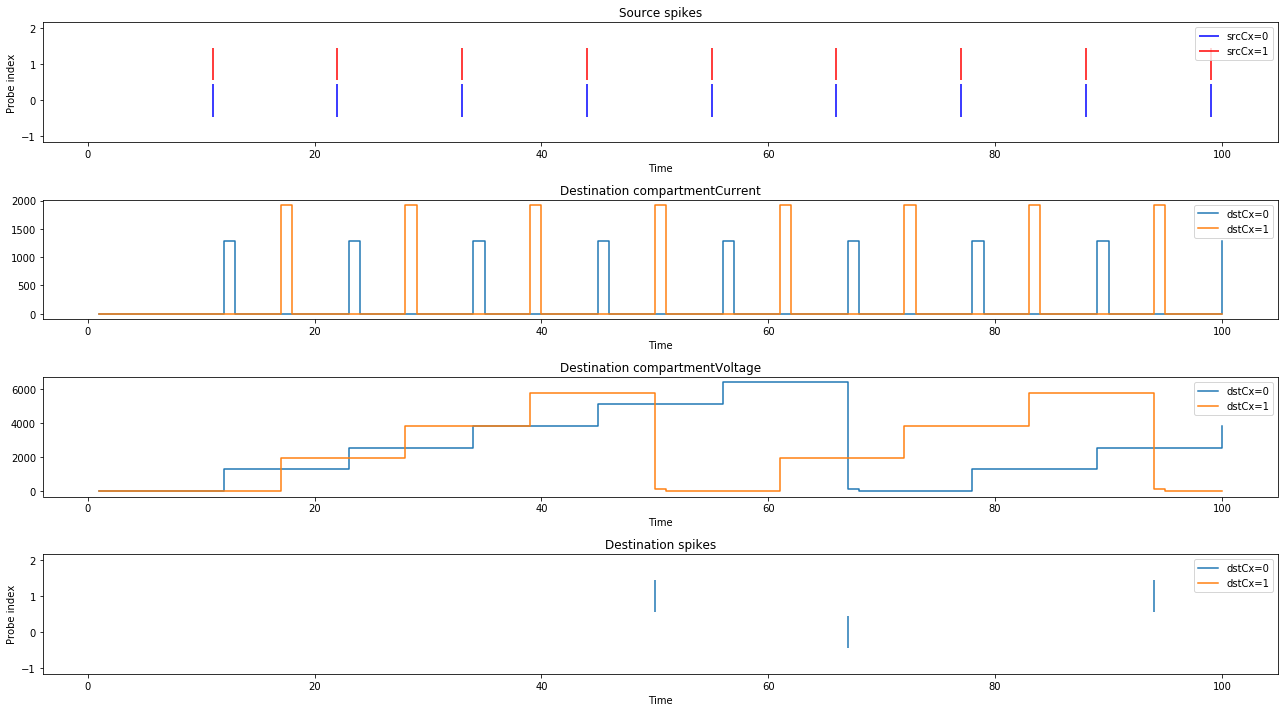

In [3]:
# Create an empty network.
net = nx.NxNet()

# Create source compartment group.
cxProtoSrc = nx.CompartmentPrototype(biasMant=1000,
                                     biasExp=6,
                                     vThMant=10000,                              
                                     functionalState=nx.COMPARTMENT_FUNCTIONAL_STATE.IDLE)
cxSrc = net.createCompartmentGroup(size=2, 
                                   prototype=cxProtoSrc)

# Create destination compartment group.
cxProtoDst = nx.CompartmentPrototype(vThMant=100,
                                     compartmentCurrentDecay=4095)
cxDst = net.createCompartmentGroup(size=2, 
                                   prototype=cxProtoDst)

# Connect compartment groups
connProto = nx.ConnectionPrototype()
conn = cxSrc.connect(cxDst, 
                     prototype=connProto, 
                     weight=np.array([[10, 20],
                                      [30, 40]]), 
                     delay=np.array([[0, 0],
                                     [5, 5]]),
                     connectionMask=np.array([[0, 1], 
                                              [1, 0]]))

# Define probes
(cxSrcSProbe,) = cxSrc.probe([nx.ProbeParameter.SPIKE])
(cxDstUProbe, cxDstVProbe, cxDstSProbe) = cxDst.probe([nx.ProbeParameter.COMPARTMENT_CURRENT,
                                                      nx.ProbeParameter.COMPARTMENT_VOLTAGE,
                                                      nx.ProbeParameter.SPIKE])

# Run network
net.run(100)
net.disconnect()

# Plot results
plt.figure(2, figsize=(18,10))

ax1 = plt.subplot(4,1,2)
uh = cxDstUProbe.plot()
plt.title('Destination compartmentCurrent')
ax1.legend(uh, ['dstCx=%d'%(i) for i in range(len(uh))])

ax2 = plt.subplot(4,1,3)
vh = cxDstVProbe.plot()
plt.title('Destination compartmentVoltage')
ax2.legend(uh, ['dstCx=%d'%(i) for i in range(len(uh))])

ax3 = plt.subplot(4,1,4)
sh = cxDstSProbe.plot()
ax3.set_xlim(ax1.get_xlim())
plt.title('Destination spikes')
ax3.legend(uh, ['dstCx=%d'%(i) for i in range(len(uh))])

ax0 = plt.subplot(4,1,1)
srch = cxSrcSProbe.plot(colors=['b', 'r'])
ax0.set_xlim(ax1.get_xlim())
plt.title('Source spikes')
ax0.legend(srch, ['srcCx=%d'%(i) for i in range(len(srch))])
    
plt.tight_layout()
plt.show()

# Source compartment srcCx=0 connects to dstCx=1 with (weight=30, delay=5) while srcCx=1 connects to dstCx=0 with
# (weight=20, delay=0) which leads to destCx=0 and destCx=1 impulses of the compartmentCurrent by 1280 and 1920,
# respectively, at 1 and 6 time steps after the source compartment spikes at t=11, ...
# The destination compartments themselves spike once their compartment voltage exceeds the membrane threshold of 6400.

## 3. Connecting compartment groups with axon delays
Axon delay is the time difference between the firing time at soma and the spike time when the destination synapse receives the spike. Parameter axonDelay can be used to configure this delay. Axonal delay applies to the axon, which means a single delay propagates to all connected synapses, while synaptic delay is applied per synapse. 

AxonDelay can be applied to destination synapses in the same core as the source axon or in a different core. In the codes below, one source compartment in Core 0 is created, which sends spikes to two destination comparments in Core 1.  Each core can only have one tEpoch, and due to hardware restriction, there is limitation of axonDelay <= 3*tEpoch. 

SLURM is being run in background
Connecting to 134.134.68.80:18861
N2Driver: Running...
    Compiling synapses... Done (0.00s)
    Processing probes... Done (0.00s)
    Writing modified registers... Done (0.08s)
    Initializing... Done (0.01s)
    Preparing input... Done (0.00s)
    Executing... Done (0.01s)
    Processing timeSeries... Done (0.01s)
N2Driver: Finished (0.12s)


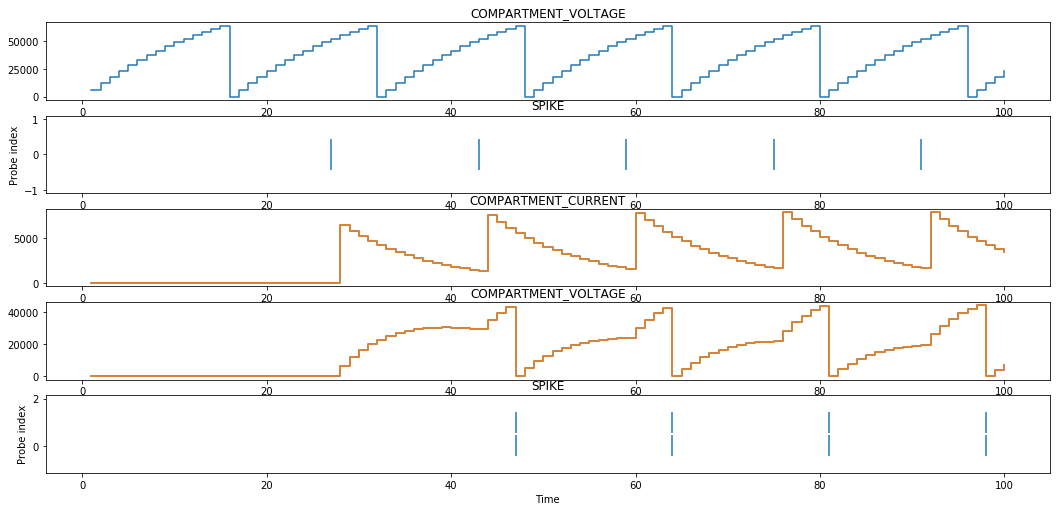

In [4]:
net = nx.NxNet()

# Create one source compartment 
p = nx.CompartmentPrototype(biasMant=100,
                            biasExp=6,
                            vThMant=1000,
                            functionalState=2,
                            compartmentCurrentDecay=409,
                            compartmentVoltageDecay=256,
                            tEpoch=6,
                            axonDelay=11,
                            logicalCoreId=0)
cxSrcGrp = net.createCompartmentGroup(size=1, prototype=p)

# Create two destination compartments
pDst = nx.CompartmentPrototype(vThMant=700,
                               compartmentCurrentDecay=409,
                               compartmentVoltageDecay=256,
                               tEpoch=0,
                               logicalCoreId=1)
cxDstGrp = net.createCompartmentGroup(size=2, prototype=pDst)

# Connect compartment groups
conn = nx.ConnectionPrototype(weight=100)
connGrp = cxSrcGrp.connect(cxDstGrp, prototype=conn)

# Define probes
(vProbes, uProbes, sProbes) = cxSrcGrp.probe([nx.ProbeParameter.COMPARTMENT_VOLTAGE,
                                              nx.ProbeParameter.COMPARTMENT_CURRENT,
                                              nx.ProbeParameter.SPIKE])
(vDstProbes, uDstProbes, sDstProbes) = cxDstGrp.probe([nx.ProbeParameter.COMPARTMENT_VOLTAGE,
                                                       nx.ProbeParameter.COMPARTMENT_CURRENT,
                                                       nx.ProbeParameter.SPIKE])

# Run network
net.run(100)
net.disconnect()

# Plot results
plt.figure(3, figsize=(18,10))
# plot source compartment voltage
ax1 = plt.subplot(6, 1, 1)
vProbes.plot()
# plot source compartment spikes with axonDelay from soma
ax2 = plt.subplot(6, 1, 2)
sProbes.plot()
ax2.set_xlim(ax1.get_xlim())
# plot destination compartments current
plt.subplot(6, 1, 3)
uDstProbes.plot()
# plot destination compartments voltage
plt.subplot(6, 1, 4)
vDstProbes.plot()
# plot destination compartments spikes
ax5 = plt.subplot(6, 1, 5)
sDstProbes.plot()
ax5.set_xlim(ax1.get_xlim())
plt.show()
# Source compartment spike sProbes shown below are not fired immediately when threshold is achieved. There is a delay 
# of axonDelay from soma firing. Destination compartments current, voltage and spike repond to the delayed source 
# compartment spikes. 

## 4. Create connections with different sign mode

SLURM is being run in background
Connecting to 134.134.68.80:18861
N2Driver: Running...
    Compiling synapses... Done (0.00s)
    Processing probes... Done (0.00s)
    Writing modified registers... Done (0.05s)
    Initializing... Done (0.01s)
    Preparing input... Done (0.00s)
    Executing... Done (0.01s)
    Processing timeSeries... Done (0.01s)
N2Driver: Finished (0.09s)


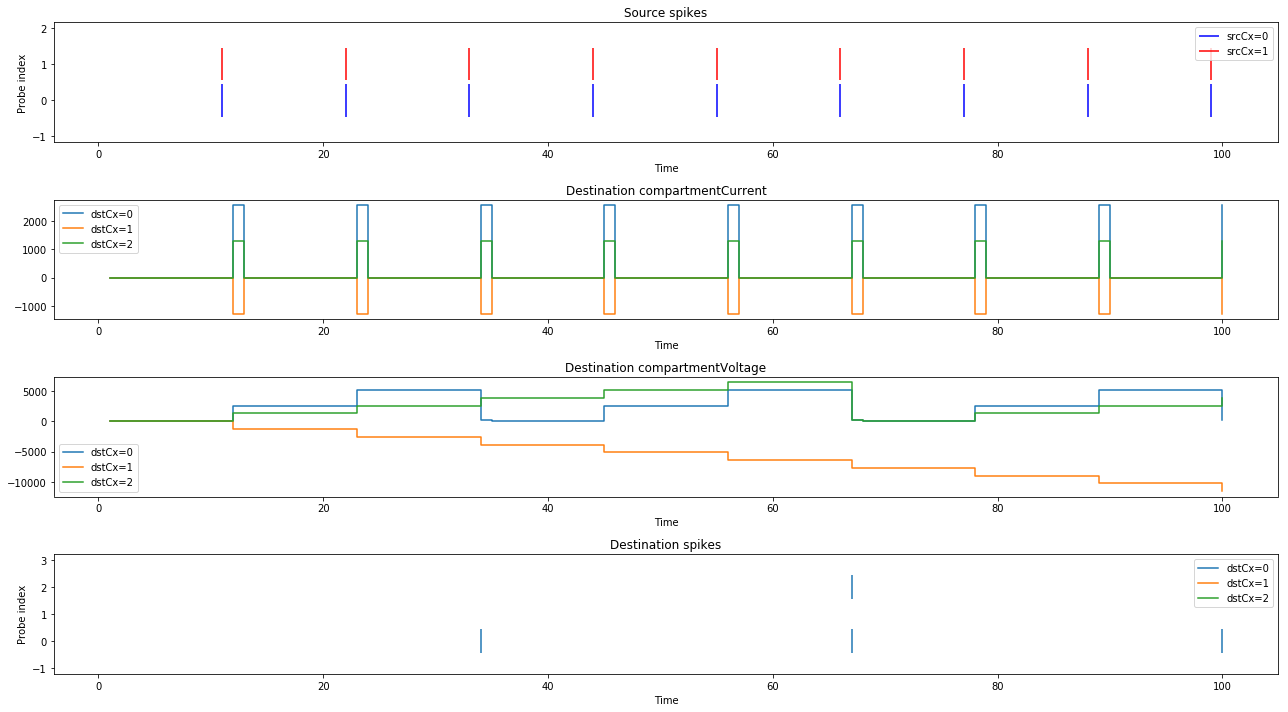

In [5]:
# Create an empty network.
net = nx.NxNet()

# Create source compartment group.
cxProtoSrc = nx.CompartmentPrototype(biasMant=1000,
                                     biasExp=6,
                                     vThMant=10000,                              
                                     functionalState=nx.COMPARTMENT_FUNCTIONAL_STATE.IDLE)
cxSrc = net.createCompartmentGroup(size=2, 
                                   prototype=cxProtoSrc)

# Create destination compartment group
cxProtoDst = nx.CompartmentPrototype(vThMant=100,
                                     compartmentCurrentDecay=4095)
cxDst = net.createCompartmentGroup(size=3, 
                                   prototype=cxProtoDst)

# Create prototypes with different sign modes for connections
connProtoEx = nx.ConnectionPrototype(signMode=nx.SYNAPSE_SIGN_MODE.EXCITATORY)
connProtoInh = nx.ConnectionPrototype(signMode=nx.SYNAPSE_SIGN_MODE.INHIBITORY)
connProtoMixed = nx.ConnectionPrototype(signMode=nx.SYNAPSE_SIGN_MODE.MIXED)

# Connect source with destination compartment group
conn = cxSrc.connect(cxDst, 
                    prototype=[connProtoEx, connProtoInh, connProtoMixed], 
                    prototypeMap=np.array([[0, 0],
                                           [1, 1],
                                           [2, 2]]),
                    weight=np.array([[  0, 40],
                                     [-20,  0],
                                     [-20, 40]]))

# Define probes
(cxSrcSProbe,) = cxSrc.probe([nx.ProbeParameter.SPIKE])
(cxDstUProbe,) = cxDst.probe([nx.ProbeParameter.COMPARTMENT_CURRENT])
(cxDstVProbe,) = cxDst.probe([nx.ProbeParameter.COMPARTMENT_VOLTAGE])
(cxDstSProbe,) = cxDst.probe([nx.ProbeParameter.SPIKE])

# Run network
net.run(100)
net.disconnect()

# Plot results
plt.figure(4, figsize=(18,10))

ax1 = plt.subplot(4,1,2)
uh = cxDstUProbe.plot()
plt.title('Destination compartmentCurrent')
ax1.legend(uh, ['dstCx=%d'%(i) for i in range(len(uh))])

ax2 = plt.subplot(4,1,3)
vh = cxDstVProbe.plot()
plt.title('Destination compartmentVoltage')
ax2.legend(uh, ['dstCx=%d'%(i) for i in range(len(uh))])

ax3 = plt.subplot(4,1,4)
sh = cxDstSProbe.plot()
ax3.set_xlim(ax1.get_xlim())
plt.title('Destination spikes')
ax3.legend(uh, ['dstCx=%d'%(i) for i in range(len(uh))])

ax0 = plt.subplot(4,1,1)
srch = cxSrcSProbe.plot(colors=['b', 'r'])
ax0.set_xlim(ax1.get_xlim())
plt.title('Source spikes')
ax0.legend(srch, ['srcCx=%d'%(i) for i in range(len(srch))])
    
plt.tight_layout()
plt.show()

# The first and second destination compartment dstCx=0/dstCx=1 receive input from excitatory/inhibitory-only synapses with
# a weight of 40/-20 and thus their compartment current increases/decreases by 40*2**6=2560 and -20*2**6=-1280,
# respectively. Thus, dstCx=0 spikes at a high frequency whereas dstCx=1 never spikes.
# The third destination compartment dstCx=2 receives input from two mixed sign synapses with a weight of
# (-20+40)*2**6=1280. Thus, dstCx=2 spikes at half the frequencey of dstCx0.

## 5. Create connections with different post synaptic response mode
There are two post synaptic response modes: EXPONENTIAL and BOX. For EXPONENTIAL, the compartment current decays exponentially with a certain time constant after each input spike whereas for BOX, the compartment current increases by the amount of the input weight, remains constant for the duration of the box profile and then decreases by the amount of the weight at once. For a BOX synapse, the synaptic delay value is interpreted as the duration of the BOX post synaptic response. A compartment should only receive input from synapses with one post synaptic response mode.

SLURM is being run in background
Connecting to 134.134.68.80:18861
N2Driver: Running...
    Compiling synapses... Done (0.00s)
    Processing probes... Done (0.00s)
    Writing modified registers... Done (0.08s)
    Initializing... Done (0.01s)
    Preparing input... Done (0.00s)
    Executing... Done (0.01s)
    Processing timeSeries... Done (0.01s)
N2Driver: Finished (0.12s)


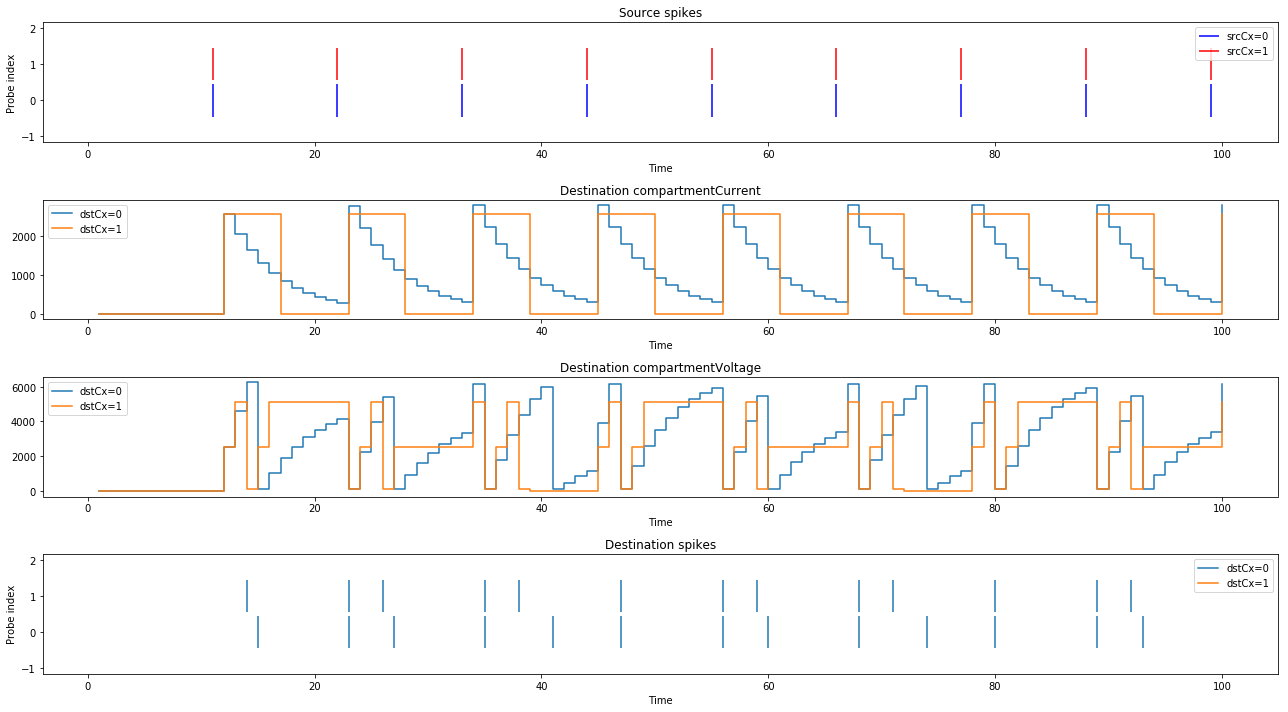

In [6]:
# Create an empty network.
net = nx.NxNet()

# Create source compartment group.
cxProtoSrc = nx.CompartmentPrototype(biasMant=1000,
                                     biasExp=6,
                                     vThMant=10000,                              
                                     functionalState=nx.COMPARTMENT_FUNCTIONAL_STATE.IDLE,
                                     logicalCoreId=0)
cxSrc = net.createCompartmentGroup(size=2, 
                                   prototype=cxProtoSrc)

# Create destination compartment group. We create one destination compartment with a finite exponential decay time
# constant which receives input from EXPONENTIAL synapses and we create another compartment without decay which receives
# input from BOX synapses.
tauU = 5
cxProtoDstExp = nx.CompartmentPrototype(vThMant=100,
                                        compartmentCurrentDecay=int(1/tauU*2**12),
                                        logicalCoreId=1)
cxProtoDstBox = nx.CompartmentPrototype(vThMant=100,
                                        compartmentCurrentDecay=0,
                                        logicalCoreId=1)
cxDst = net.createCompartmentGroup(size=2, 
                                   prototype=[cxProtoDstExp, cxProtoDstBox],
                                   prototypeMap=[0, 1])

# Create prototypes with different post synaptic response modes and a default weight.
connProtoExp = nx.ConnectionPrototype(weight=20,
                                      postSynResponseMode=nx.SYNAPSE_POST_SYN_RESPONSE_MODE.EXPONENTIAL)
connProtoBox = nx.ConnectionPrototype(weight=20,
                                      postSynResponseMode=nx.SYNAPSE_POST_SYN_RESPONSE_MODE.BOX)

# Connect source with destination compartment group. For the second compartment we set a synaptic delay of 5 which will
# be interpreted as the duration of the BOX post synaptic response profile.
conn = cxSrc.connect(cxDst, 
                    prototype=[connProtoExp, connProtoBox], 
                    prototypeMap=np.array([[0, 0],
                                           [1, 1]]),
                    delay=np.array([[0, 0],
                                    [5, 5]])) 

# Define probes
(cxSrcSProbe,) = cxSrc.probe([nx.ProbeParameter.SPIKE])
(cxDstUProbe,) = cxDst.probe([nx.ProbeParameter.COMPARTMENT_CURRENT])
(cxDstVProbe,) = cxDst.probe([nx.ProbeParameter.COMPARTMENT_VOLTAGE])
(cxDstSProbe,) = cxDst.probe([nx.ProbeParameter.SPIKE])

# Run network
net.run(100)
net.disconnect()

# Plot results
plt.figure(5, figsize=(18,10))

ax1 = plt.subplot(4,1,2)
uh = cxDstUProbe.plot()
plt.title('Destination compartmentCurrent')
ax1.legend(uh, ['dstCx=%d'%(i) for i in range(len(uh))])

ax2 = plt.subplot(4,1,3)
vh = cxDstVProbe.plot()
plt.title('Destination compartmentVoltage')
ax2.legend(uh, ['dstCx=%d'%(i) for i in range(len(uh))])

ax3 = plt.subplot(4,1,4)
sh = cxDstSProbe.plot()
ax3.set_xlim(ax1.get_xlim())
plt.title('Destination spikes')
ax3.legend(uh, ['dstCx=%d'%(i) for i in range(len(uh))])

ax0 = plt.subplot(4,1,1)
srch = cxSrcSProbe.plot(colors=['b', 'r'])
ax0.set_xlim(ax1.get_xlim())
plt.title('Source spikes')
ax0.legend(srch, ['srcCx=%d'%(i) for i in range(len(srch))])
    
plt.tight_layout()
plt.show()

# The first destination compartment dstCx=0 receives only input from exponential synapses and has a finite compartment
# current decay time constant. As a result, its compartmentCurrent decays exponentially after each input spike.
# In contrast, the second destination compartment dstCx=1 receives only input from box synapses, therefore its
# compartmentCurrent remains constant for the duration of the post synaptic response and then drops to zero instantly.

.. code-links:: python clear